# Portfolio Rebalancer in Python

# Instructions
To use this interactive portfolio rebalancer, you can change the settings in the two cells below. Once you have your inputs set to your liking, go to the top menu bar and select 'Kernel -> Restart & Run All' then click the red "Restart and Run All Cells' button on the pop up dialog. The entire code will now re-reun with your updated inputs. After about 15-30 seconds it should complete and you will see your rebalanced portfolio at the bottom. If there are errors with the Tiingo API its likely because the API key I provided for this interactive demo has been overused by interested users like you! Its easy enough to register your own API key at [Tiingo](https://api.tiingo.com/) (its free). Once you have your own API key, just uncomment the line "tiingo_key = 'YOURKEYGOESHERE'" and replace your key inbetween the single quotes and re-run.  

You can see the original post here: [evgenypogorelov.com](https://evgenypogorelov.com/portfolio-rebalancing-python.html#portfolio-rebalancing-python)  
And the git repo: https://github.com/pogoetic/rebalance  

Last, but not least, a huge shoutout and thanks to the team behind [Binder](https://mybinder.org/), its an amazing tool that lets me host this interactive Jupyter notebook for free, and enables you to play around with the code in a real environment. Have fun! Post questions or feedback in the comments.  
  

In [3]:
#Settings
new_money_in = 10000
#Set our rebalance threshold
rebal_threshold = .05 #allowable allocation drift
rebal_timeframe = 180 #in days

In [4]:
#Define target and current allocations
#create our target allocation
columns_t = ['ticker','allocation_target','assetclass']
positions_t = [['VTSAX',0.5652,'ST'],
               ['VIGAX',0.0131,'ST'],
               ['VSMAX',0.0066,'ST'],
               ['VSEQX',0.0066,'ST'],
               ['VWIGX',0.0507,'ST'],
               ['VTRIX',0.0507,'ST'],
               ['VTIAX',0.1521,'ST'],
               ['VBTLX',0.035,'BD'],
               ['VTABX',0.015,'BD'],
               ['VGSLX',0.05,'RE'],
               ['VNQI',0.01,'RE'],
               ['VDE',0.03,'ST'],
               ['GLD',0.015,'CS']]

#set our current portfolio
columns_c = ['accounttype','accountid','lastrebaldate','ticker','assetclass','basisdate','costbasis','shares']
positions_c = [['RIRA','1111','2018-11-16','VBTLX','BD','2018-11-16',1,913.483],
             ['RIRA','1111','2018-11-16','VTIAX','ST','2018-11-16',1,514.298],
             ['RIRA','1111','2018-11-16','VTSAX','ST','2018-11-16',10,151.121],
             ['RIRA','2222','2018-11-16','VBTLX','BD','2018-11-16',1,772.407],
             ['RIRA','2222','2018-11-16','VTSAX','ST','2018-11-16',20,151.578],
             ['TAXB','3333','2018-11-16','AAPL','ST','2018-11-16',1,3.14],
             ['TAXB','3333','2018-11-16','VTSAX','ST','2018-11-16',10,549.871]]

### WARNING: Above this cell are settings you can change and test with. Below this cell is code you shouldn't touch unless you know Python

In [2]:
#Lets import the necessary packages
import pandas as pd
from IPython.display import display
pd.set_option('display.max_columns', None)
import numpy as np
import datetime
import decimal
from pandas_datareader import data as pdr
from keys import tiingo_key
#define todays datetime
now = datetime.datetime.now()
#uncomment below to override tiingo_key with your own! 
#tiingo_key = 'YOURKEYGOESHERE'

In [5]:
#lookup table for account type abbreviations
accounttypes = {'TAXB':'Taxable Brokerage', '401K':'401k', 'RIRA':'Roth-IRA', 'TIRA':'Traditional-IRA'}
assetclasses = {'ST':'Equity Stocks', 'BD':'Bonds Fixed-Income', 'CS':'Cash and Commodities', 'RE':'Real-Estate', 'ALT':'Alternatives'}
assettypes = {'SEC':'Individual Security', 'ETF':'Exchange Traded Fund', 'MF': 'Mutual Fund', 'IF':'Index Fund'}
assetregion = {'D':'Domestic','I':'International'}

#initialize target portfolio
targetalloc = pd.DataFrame(columns = columns_t, data = positions_t)
total=decimal.Decimal(targetalloc.allocation_target.sum())
#check that our target allocation indeed adds to 100%
assert round(total,4) == 1,'Target Allocation not 100% : {}'.format(int(total))

#initialize current portfolio
start_port = pd.DataFrame(columns = columns_c, data = positions_c)
start_port.lastrebaldate = pd.to_datetime(start_port.lastrebaldate)
start_port.basisdate = pd.to_datetime(start_port.basisdate)

#custom apply function
def f(x):
    d = {}
    d['lastrebaldate'] = x['lastrebaldate'].max()
    d['assetclass'] = x['assetclass'].max()
    d['basisdate'] = x['basisdate'].min()
    d['costbasis'] = (x['costbasis'] * x['shares']).sum()/(x['shares'].sum() or 1) #weighted avg
    d['shares'] = x['shares'].sum()
    return pd.Series(d, index=['lastrebaldate', 'assetclass', 'basisdate', 'costbasis', 'shares'])

#aggregate by ticker to account for duplicate securities held in different accounts
agg_port = start_port.groupby(['ticker']).apply(f)

#Define list of distinct tickers we care about
tickers = set(targetalloc.ticker.unique().tolist()+start_port.ticker.unique().tolist())

In [6]:
#Next we pull the latest prices from Tiingo (YahooFinance is buggy, and IEX does not contain mutual fund data)
#Tiingo limits for free API: 500 unique tickers ever, 500 requests/hr, 20,000 requests/day
#https://pandas-datareader.readthedocs.io/en/latest/remote_data.html#tiingo
#Tiingo API key required: set 'tiingo_key' value in python file called 'keys.py' in same directory as this script
now = datetime.datetime.now()
yesterday = now - datetime.timedelta(3) #avoids weekends with no data - need better weekend detection
start = datetime.datetime(yesterday.year, yesterday.month, yesterday.day)
end = datetime.datetime(now.year, now.month, now.day)

bad_tickers = []
for i, t in enumerate(tickers):
    try:
        if i==0:
            ohlc = pdr.get_data_tiingo(t, api_key=tiingo_key).tail(1).close
        else:
            ohlc = ohlc.append(pdr.get_data_tiingo(t, api_key=tiingo_key).tail(1).close)
    except:
        bad_tickers.append(t)
        
#print(bad_tickers)
ohlc = ohlc.to_frame(name='close')

#drop our date index since its only the latest data
ohlc2=ohlc.reset_index(level=1, drop=True)

#Manual fix for known bad_tickers which Tiingo can't find, adjust to suit your needs
if 'VMFXX' in bad_tickers:
    ohlc2.loc['VMFXX'] = 1.0

In [7]:
#concatenate target allocation and latest prices with our portfolio
start_port_c = pd.merge(agg_port, targetalloc, on ='ticker', how ='outer')
final_port = pd.merge(start_port_c, ohlc2, left_on ='ticker', right_index = True, how = 'left')

#set target to zero for tickers held but not present in our target allocation, set initial basisdate and costbasis for new securities entering the portfolio
final_port.fillna(value = {'allocation_target':0.0,'shares':0.0,'basisdate':pd.to_datetime(now.strftime("%Y-%m-%d")),'costbasis':final_port.close,'assetclass_x':final_port.assetclass_y},inplace = True)
final_port.drop(['assetclass_y'],axis=1,inplace=True)
final_port.rename(columns={'assetclass_x':'assetclass'},inplace=True)

#calculate holding values and current allocation
final_port['value'] = final_port.close * final_port.shares #calculate value as price x shares
final_port.loc[final_port.value.isna() & final_port.shares.isna(),['value']]=0.0 #for securities not currently held but in our target (and close price failed to return), establish zero value
final_port['allocation'] = final_port.value / final_port.value.sum()
final_port['correction'] = final_port.allocation_target - final_port.allocation
final_port['new_money_in'] = new_money_in * final_port.allocation_target #Account for new money in

In [8]:
#create timedelta int column
final_port['timedelta'] = (final_port.lastrebaldate - pd.to_datetime(now.strftime("%Y-%m-%d"))).dt.days
final_port.timedelta.fillna(0,inplace=True)

#define rebalance flags to determine if we must rebalance
final_port['rebal_flag_thresh'] = np.where((abs(final_port.correction)<=rebal_threshold) & (final_port.allocation > 0),0,1)
final_port['rebal_flag_time'] = np.where(final_port.timedelta >= rebal_timeframe,1,0)
final_port['rebal_flag_exit'] = np.where((final_port.allocation > 0) & (final_port.allocation_target==0),1,0) #force rebal securities not present in our target portfolio
final_port['rebal_flag_newmoney'] = np.where(final_port.new_money_in>0,1,0)
final_port['rebal_flag'] = np.where(final_port.rebal_flag_thresh + final_port.rebal_flag_time + final_port.rebal_flag_exit + final_port.rebal_flag_newmoney >= 1,1,0)

#Subset of securities we need to rebalance, and those we need to leave alone
rebal_port = final_port[final_port.rebal_flag==1].copy()
stable_port = final_port[final_port.rebal_flag==0].copy()

In [9]:
#Calculate our current allocation, target, and the change we need to hit target
total_val = rebal_port.value.sum()
rebal_port['allocation'] = rebal_port.value/rebal_port.value.sum()
rebal_port['allocation_target'] = rebal_port.allocation_target/rebal_port.allocation_target.sum()
rebal_port['correction'] = rebal_port.allocation_target - rebal_port.allocation

#Factor in any new money entering the portfolio and determine necessary changes in value and shares
rebal_port['value_chg'] = (total_val * rebal_port.correction) + rebal_port.new_money_in
rebal_port['shares_chg'] = rebal_port.value_chg / rebal_port.close
rebal_port.loc[rebal_port.value_chg.isna() & rebal_port.shares > 0,['shares_chg']]=-rebal_port.shares #sell all shares of securities not in our target portfolio

#Round off shares to whole numbers, except when we are fully exiting a position
rebal_port['shares_chg_round'] = rebal_port.shares_chg
rebal_port = rebal_port.astype({'shares_chg_round': int})
rebal_port['final_shares_chg'] = rebal_port.shares_chg
rebal_port.loc[np.round(rebal_port.shares_chg+rebal_port.shares)!=0,['final_shares_chg']]=rebal_port.shares_chg_round*1.0
rebal_port.drop(['shares_chg_round'],axis=1,inplace=True)

#Calculate initial new shares and values
rebal_port['new_shares'] = np.round(rebal_port.shares + rebal_port.final_shares_chg,3)
rebal_port['new_value'] = rebal_port.new_shares * rebal_port.close #due to share rounding, there will be slight variance vs. portfolio starting value
rebal_port['new_value_chg'] = rebal_port.final_shares_chg * rebal_port.close

In [10]:
#Double check our work so far
#net of buying and selling should be zero
assert(np.round(rebal_port.value_chg.sum(),3)-new_money_in==0) 
#make sure totals match (with rounding error + new money in) from original portfolio and rebalanced portfolio
assert(np.round(rebal_port.new_value.sum() - rebal_port.value.sum(),3)==np.round((rebal_port.new_value.sum() + stable_port.value.sum()) - final_port.value.sum(),3))

In [11]:
#Merge our rebalanced portfolio with our stable portfolio for our execution portfolio
stable_port['value_chg'] = 0
stable_port['shares_chg']=0
stable_port['final_shares_chg'] = 0
stable_port['new_value_chg'] = 0
stable_port['new_shares'] = stable_port.shares
stable_port['new_value'] = stable_port.value
exec_port = pd.concat([rebal_port,stable_port],sort=False)
exec_port.drop(columns=['timedelta','rebal_flag_thresh','rebal_flag_time','rebal_flag_exit','rebal_flag_newmoney','value_chg','shares_chg'],inplace=True)

#Reset allocations to be based on all securities
exec_port['allocation'] = exec_port.value/exec_port.value.sum()
exec_port['allocation_target'] = exec_port.allocation_target/exec_port.allocation_target.sum()
exec_port['correction'] = exec_port.allocation_target - exec_port.allocation
exec_port['final_allocation'] = exec_port.new_value / exec_port.new_value.sum()

In [12]:
#Lets look at all our work to get to our target portfolio
exec_port

,ticker,lastrebaldate,assetclass,basisdate,costbasis,shares,allocation_target,close,value,allocation,correction,new_money_in,rebal_flag,final_shares_chg,new_shares,new_value,new_value_chg,final_allocation
0,AAPL,2018-11-16,ST,2018-11-16,1.000000,3.140,0.0000,156.15,490.31100,0.005905,-0.005905,0.0,1,-3.14,0.000,0.00000,-490.311,0.000000
1,VBTLX,2018-11-16,BD,2018-11-16,1.000000,1685.890,0.0350,10.39,17516.39710,0.210973,-0.175973,350.0,1,-1372.00,313.890,3261.31710,-14255.080,0.035196
2,VTIAX,2018-11-16,ST,2018-11-16,1.000000,514.298,0.1521,25.17,12944.88066,0.155913,-0.003813,1521.0,1,47.00,561.298,14127.87066,1182.990,0.152468
3,VTSAX,2018-11-16,ST,2018-11-16,11.777895,852.570,0.5652,61.08,52074.97560,0.627209,-0.062009,5652.0,1,8.00,860.570,52563.61560,488.640,0.567266
4,VIGAX,NaT,ST,2018-12-27,68.020000,0.000,0.0131,68.02,0.00000,0.000000,0.013100,131.0,1,17.00,17.000,1156.34000,1156.340,0.012479
5,VSMAX,NaT,ST,2018-12-27,62.250000,0.000,0.0066,62.25,0.00000,0.000000,0.006600,66.0,1,9.00,9.000,560.25000,560.250,0.006046
6,VSEQX,NaT,ST,2018-12-27,26.770000,0.000,0.0066,26.77,0.00000,0.000000,0.006600,66.0,1,22.00,22.000,588.94000,588.940,0.006356
7,VWIGX,NaT,ST,2018-12-27,24.760000,0.000,0.0507,24.76,0.00000,0.000000,0.050700,507.0,1,190.00,190.000,4704.40000,4704.400,0.050770
8,VTRIX,NaT,ST,2018-12-27,31.910000,0.000,0.0507,31.91,0.00000,0.000000,0.050700,507.0,1,147.00,147.000,4690.77000,4690.770,0.050623
9,VTABX,NaT,BD,2018-12-27,21.660000,0.000,0.0150,21.66,0.00000,0.000000,0.015000,150.0,1,64.00,64.000,1386.24000,1386.240,0.014960


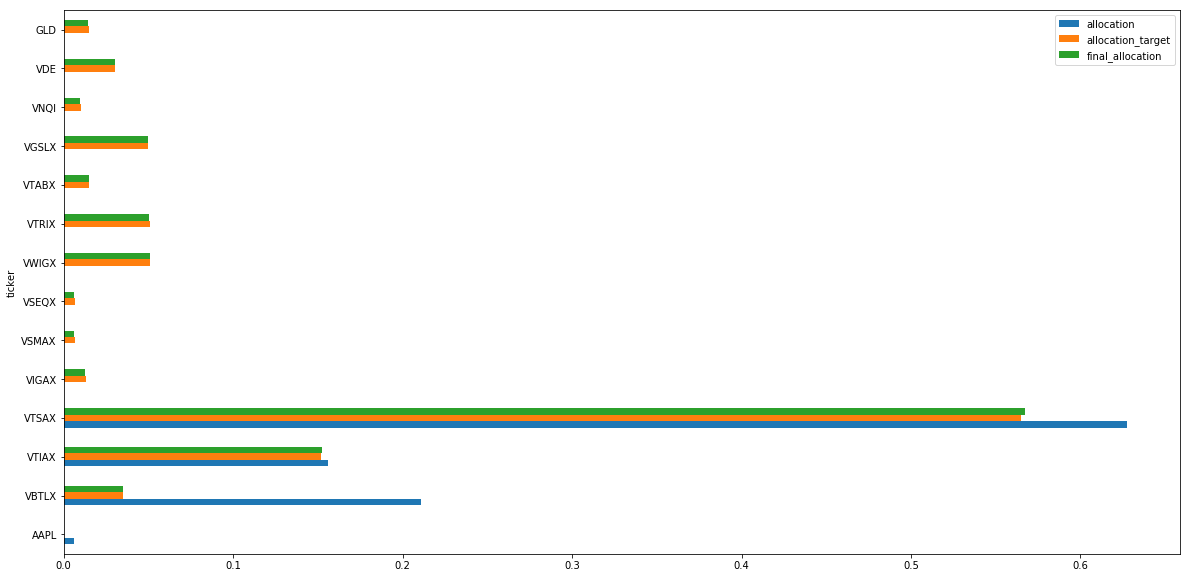

In [20]:
#Lets add a bar chart here to show the new allocation vs. the target allocation and vs. the original portfolio
graph_port = exec_port[['ticker','allocation','allocation_target','final_allocation']].copy()
graph_port.plot.barh(x='ticker',figsize=(20,10))

In [24]:
#Next we turn our ticker-level strategy into account level actions
#Join in our rebalanced portfolio and determine how to split value across accounts for a given ticker
port = pd.merge(start_port[['accounttype','accountid','ticker','shares']], 
                   exec_port[['ticker','assetclass','close','value','final_shares_chg','new_shares','new_value','new_value_chg','final_allocation']], 
                   how = 'right', 
                   left_on = 'ticker', 
                   right_on = 'ticker')
port['value_orig'] = port.close * port.shares
#Calculate the value-weight of each ticker by account
port['tick_alloc'] = port.value_orig / port.value #What pct of each ticker is in a given account?
port['tick_alloc'].fillna(1.0,inplace=True)

#check our sub-allocations
assert(port.groupby('ticker').tick_alloc.sum().sum() == len(port.groupby('ticker').tick_alloc.sum()))

#Recalculate the values proportionately
port['final_shares_chg_n'] = port.final_shares_chg * port.tick_alloc
port['new_shares_n'] = port.new_shares * port.tick_alloc
port['new_value_n'] = port.new_value * port.tick_alloc
port['new_value_chg_n'] = port.new_value_chg * port.tick_alloc
port['final_allocation_n'] = port.final_allocation * port.tick_alloc

#double check our final_allocation is 100%
assert(np.round(port.final_allocation_n.sum(),4)==1.0)

#Now we must double check to ensure we are not allocating buys to accounts with no sells (we cannot just add funds to a Traditional IRA account, for example)
#accounts with single securities in them which also exist in other accounts can cause issues if we don't do this
acctsdf = port.groupby(['accountid','accounttype']).new_value_chg_n.sum()
acctsdf = acctsdf.reset_index().rename(columns={'new_value_chg_n':'new_value_chg_sum'})
errordf = acctsdf[acctsdf.new_value_chg_sum > 0].copy() #a value >0 at the account-level implies we have allocated buys to an account with insufficient sells
erroraccts = errordf.accountid.values
if len(errordf) > 0: 
    for t in port[port.accountid.isin(erroraccts)].ticker.unique(): #Loop by security (not by account)
        print("Correcting distribution for single-security accounts edge case: {}".format(t))
        index = (port.accountid.isin(erroraccts)) & (port.ticker == t)
        display(port[port.ticker == t])
        #adjust numerator and denominator for proper recalculation of asset distribution across accounts
        port.loc[index,'new_shares_n'] = port.new_shares_n - port.final_shares_chg_n
        port.loc[index,'new_value_n'] = port.new_value_n - port.new_value_chg_n
        port.loc[index,'final_shares_chg_n'] = 0
        port.loc[index,'new_value_chg_n'] = 0

        #remove from denominator
        port.loc[port.ticker == t,'value'] = port.loc[port.ticker == t,'value'] - port[index].value_orig.sum()
        
        #recalculate values for this ticker
        port.loc[port.ticker == t,'tick_alloc'] = port[port.ticker == t].value_orig / port[port.ticker == t].value
        port.loc[index,'tick_alloc'] = 0 #set new money allocation to zero for funds with insufficient assets
        port.loc[port.ticker == t,'final_shares_chg_n'] = port.final_shares_chg * port.tick_alloc
        port.loc[port.ticker == t,'new_shares_n'] = port.shares + port.final_shares_chg_n
        port.loc[port.ticker == t,'new_value_chg_n'] = port.new_value_chg * port.tick_alloc
        port.loc[port.ticker == t,'new_value_n'] = port.value_orig + port.new_value_chg_n
        port.loc[port.ticker == t,'final_allocation_n'] = (port.new_value_n / port.new_value) * port.final_allocation
        
        display(port[port.ticker == t])


#Cleanup
port['value'] = port.value_orig
port['final_shares_chg'] = port.final_shares_chg_n
port['new_shares'] = port.new_shares_n
port['new_value'] = port.new_value_n
port['new_value_chg'] = port.new_value_chg_n
port['final_allocation'] = port.final_allocation_n
port.drop(['value_orig','tick_alloc','final_shares_chg_n','new_shares_n','new_value_n','new_value_chg_n','final_allocation_n'],axis=1,inplace=True)
port.fillna({'value':0.0},inplace=True)

#Check our work
assert(np.round(port.final_allocation.sum(),4)==1.0)
assert(np.round(np.sum((port.shares+port.final_shares_chg)-port.new_shares))==0)
assert(np.round(np.sum(port.new_value-(port.new_shares*port.close)))==0)
assert(np.round(np.sum(port.new_value_chg-(port.final_shares_chg*port.close)))==0)

#Lets look at our final portfolio at the account level
display(port)

,accounttype,accountid,ticker,shares,assetclass,close,value,final_shares_chg,new_shares,new_value,new_value_chg,final_allocation
0,RIRA,1111,VBTLX,913.483,BD,10.39,9491.08837,-743.404775,170.078225,1767.112759,-7723.975611,0.019071
1,RIRA,2222,VBTLX,772.407,BD,10.39,8025.30873,-628.595225,143.811775,1494.204341,-6531.104389,0.016125
2,RIRA,1111,VTIAX,514.298,ST,25.17,12944.88066,47.000000,561.298000,14127.870660,1182.990000,0.152468
3,RIRA,1111,VTSAX,151.121,ST,61.08,9230.47068,1.418028,152.539028,9317.083821,86.613141,0.100550
4,RIRA,2222,VTSAX,151.578,ST,61.08,9258.38424,1.422316,153.000316,9345.259305,86.875065,0.100854
5,TAXB,3333,VTSAX,549.871,ST,61.08,33586.12068,5.159656,555.030656,33901.272475,315.151795,0.365862
6,TAXB,3333,AAPL,3.140,ST,156.15,490.31100,-3.140000,0.000000,0.000000,-490.311000,0.000000
7,NaN,NaN,VIGAX,NaN,ST,68.02,0.00000,17.000000,17.000000,1156.340000,1156.340000,0.012479
8,NaN,NaN,VSMAX,NaN,ST,62.25,0.00000,9.000000,9.000000,560.250000,560.250000,0.006046
9,NaN,NaN,VSEQX,NaN,ST,26.77,0.00000,22.000000,22.000000,588.940000,588.940000,0.006356


In [30]:
#Finally, all new tickers need an account to land in
dport = None
acctsdf = None
if len(port[port.accounttype.isnull()])>0: #if we have none, skip this step
    print('Distributing new securities to existing accounts . . .')
    dport = port.copy()

    #account-level fund surplus or deficit - must match these with our orphaned securities
    acctsdf = port.groupby(['accountid','accounttype']).new_value_chg.sum()
    acctsdf = acctsdf.reset_index().rename(columns={'new_value_chg':'new_value_chg_sum'})
    #establish sort order so we can allocate tax-efficient account space first
    actype_sortorder = pd.DataFrame(data=[['RIRA',1],['TIRA',2],['TAXB',3]],columns=['accounttype','order'])
    acctsdf = pd.merge(acctsdf,actype_sortorder,how='left',left_on='accounttype',right_on='accounttype')
    #We make a consequential assumption here that any new_money_in will be allocated 100% in one of the Taxable accounts (first in list).
    #if you have a Roth-IRA which has not met its contribution limits for the year, it may be preferrential to distribute the funds there first.
    #IF YOU HAVE NO TAXABLE ACCOUNT AND YOU WISH TO REBALANCE WITH new_money_in > 0 this will cause errors - so we assert here:
    assert(new_money_in == 0 or (len(acctsdf[acctsdf.accounttype == 'TAXB'])>0 and new_money_in > 0))
    min_idx = acctsdf[acctsdf.accounttype == 'TAXB'].index.min()
    acctsdf.loc[min_idx,'new_value_chg_sum'] = acctsdf.loc[min_idx,'new_value_chg_sum'] - new_money_in
    #only return accounts that have space
    acctsdf = acctsdf[acctsdf.new_value_chg_sum<0].copy()

    #establish sort order so we can allocate tax-inefficient assets first
    aclass_sortorder = pd.DataFrame(data=[['ST',3],['BD',1],['CS',4],['RE',2],['ALT',5]],columns=['assetclass','order'])
    dport = pd.merge(dport,aclass_sortorder,how='left',left_on='assetclass',right_on='assetclass')

    #We loop twice, first to fit whole securities in accounts with tax location in mind, then again without tax location for anything leftover
    loop = 0
    while loop < 2:
        loop+=1
        #loop through orphaned tickers and place them in accounts until all assets are allocated or we are forced to split a security across accounts
        #  in the first loop we do not allow tax-inefficient assets to wind up in Taxable accounts, in the second loop we relax this constraint
        for index, row in dport[dport.accounttype.isnull()].sort_values(['order','new_value_chg'],ascending=[True,False]).iterrows():
            #loop through accounts and place the assets
            for i, r in acctsdf.iterrows():
                aid = r.accountid
                atype = r.accounttype
                bal = r.new_value_chg_sum
                #print('Evaluating {}-{} with {} starting bal'.format(aid,atype,bal))
                if loop == 0 and (row.assetclass in ('BD','RE') and atype == 'TAXB'):
                    continue #skip this case, since we don't want to place Bonds and Real-Estate assets in Taxable accounts
                elif loop == 0 and (row.assetclass not in ('BD','RE') and atype != 'TAXB'):
                    continue #skip this case, since we don't want to place tax-efficient assets into tax sheltered accounts 

                if row.new_value_chg + bal <=0: #it fits
                    bal+=row.new_value_chg
                    print(' FITS {} in {}-{} with {} remaining'.format(row.ticker,aid,atype,bal))
                    #update our portfolio
                    dport.loc[index,'accountid'] = aid
                    dport.loc[index,'accounttype'] = atype
                    #update account bal for next loop
                    acctsdf.loc[i,'new_value_chg_sum'] = bal
                    break
                else:
                    print(' {} {} does not fit in {}-{}'.format(row.ticker,row.new_value_chg,aid,atype))
    
    print('\nLets see what remains in our accounts after 2 loops . . .')
    display(acctsdf)
                    
    #Here we are forced to split a security across multiple accounts because no one account can fit it
    #  in this loop we allow tax-inefficient assets to wind up in Taxable accounts, but only as a last resort
    if len(dport[dport.accounttype.isnull()])>0:
        print('Splitting remaining securities across accounts . . .')
        #loop through accounts and place portions of asset in each, create a new row in the df for each placement.
        for index, row in dport[dport.accounttype.isnull()].sort_values(['order','new_value_chg'],ascending=[True,False]).iterrows():
            final_shares_chg = row.final_shares_chg
            asset_bal = row.new_value_chg
            #if its a tax-inefficent asset, order the accounts by 'order'
            if row.assetclass in ('BD','RE'):
                acctsdf = acctsdf.sort_values('order',ascending=True)
            else:
                acctsdf = acctsdf.sort_values('order',ascending=False)
            
            for i, r in acctsdf.iterrows():
                bal = r.new_value_chg_sum
                if asset_bal>-bal:
                    to_move = -bal
                    pct_move = -bal/row.new_value_chg
                    asset_bal+=bal
                else:
                    to_move = asset_bal
                    pct_move = asset_bal/row.new_value_chg
                    asset_bal=0
                print(' {} move {} or {}% into account {}-{}. {} bal remaining {}'.format(row.ticker,to_move,pct_move,r.accountid,r.accounttype,row.ticker,asset_bal))
                
                #update our account to reflect this change
                if asset_bal > 0:
                    acctsdf.loc[i,'new_value_chg_sum'] = 0.0
                else:
                    acctsdf.loc[i,'new_value_chg_sum'] = to_move+bal
                
                if (np.floor(pct_move*row.new_shares)*row.close)-row.value > 0:
                    #create new row in our portfolio for this asset in this account
                    dport.loc[max(dport.index)+1] = [r.accounttype,
                                            r.accountid,
                                            row.ticker,
                                            row.shares,
                                            row.assetclass,
                                            row.close,
                                            row.value,
                                            np.floor(pct_move*row.final_shares_chg), #we round down to get back to whole shares
                                            np.floor(pct_move*row.new_shares),
                                            np.floor(pct_move*row.new_shares)*row.close,
                                            (np.floor(pct_move*row.new_shares)*row.close)-row.value, #rounding can cause us to be short of our total allocatable funds
                                            np.floor(pct_move*row.new_value)/dport.new_value.sum(),
                                            row.order]
    
                #finally delete the original row from the df
                dport.drop(dport[dport.accounttype.isnull()].index,inplace=True)
            
                #double check our work - we just care that distributed funds < total available funds for this ticker
                assert(dport[dport.ticker==row.ticker].new_value_chg.sum() < row.new_value_chg)

Distributing new securities to existing accounts . . .
 FITS VTABX in 1111-RIRA with -5068.132470695083 remaining
 FITS VGSLX in 1111-RIRA with -445.4924706950824 remaining
 VNQI 884.8499999999999 does not fit in 1111-RIRA
 FITS VNQI in 2222-RIRA with -5559.379323808596 remaining
 VWIGX 4704.400000000001 does not fit in 1111-RIRA
 FITS VWIGX in 2222-RIRA with -854.9793238085958 remaining
 VTRIX 4690.77 does not fit in 1111-RIRA
 VTRIX 4690.77 does not fit in 2222-RIRA
 FITS VTRIX in 3333-TAXB with -5484.389205496322 remaining
 VDE 2787.84 does not fit in 1111-RIRA
 VDE 2787.84 does not fit in 2222-RIRA
 FITS VDE in 3333-TAXB with -2696.5492054963215 remaining
 VIGAX 1156.34 does not fit in 1111-RIRA
 VIGAX 1156.34 does not fit in 2222-RIRA
 FITS VIGAX in 3333-TAXB with -1540.2092054963216 remaining
 VSEQX 588.9399999999999 does not fit in 1111-RIRA
 FITS VSEQX in 2222-RIRA with -266.0393238085959 remaining
 VSMAX 560.25 does not fit in 1111-RIRA
 VSMAX 560.25 does not fit in 2222-RIRA


,accountid,accounttype,new_value_chg_sum,order
0,1111,RIRA,-445.492471,1
1,2222,RIRA,-266.039324,1
2,3333,TAXB,-979.959205,3


Splitting remaining securities across accounts . . .
 GLD move 979.9592054963216 or 0.7388836402062338% into account 3333-TAXB. GLD bal remaining 346.3107945036784
 GLD move 346.3107945036784 or 0.26111635979376624% into account 1111-RIRA. GLD bal remaining 0
 GLD move 0 or 0.0% into account 2222-RIRA. GLD bal remaining 0


In [31]:
#Lets see whats left in our accounts, it should be very close to zero
if acctsdf is not None:
    display(acctsdf)

,accountid,accounttype,new_value_chg_sum,order
2,3333,TAXB,0.000000,3
0,1111,RIRA,-99.181676,1
1,2222,RIRA,-266.039324,1


In [32]:
#Review our final portfolio with recommended buys/sells in 'final_shares_chg' column
if dport is not None:
    #Cleanup
    dport.drop(columns=['order'],inplace=True)
    dport = dport[['accounttype','accountid','ticker','shares','assetclass','close','value','new_shares','final_shares_chg','new_value','new_value_chg','final_allocation']]
    display(dport)
else:
    port = port[['accounttype','accountid','ticker','shares','assetclass','close','value','new_shares','final_shares_chg','new_value','new_value_chg','final_allocation']]
    display(port)

,accounttype,accountid,ticker,shares,assetclass,close,value,new_shares,final_shares_chg,new_value,new_value_chg,final_allocation
0,RIRA,1111,VBTLX,913.483,BD,10.39,9491.08837,170.078225,-743.404775,1767.112759,-7723.975611,0.019071
1,RIRA,2222,VBTLX,772.407,BD,10.39,8025.30873,143.811775,-628.595225,1494.204341,-6531.104389,0.016125
2,RIRA,1111,VTIAX,514.298,ST,25.17,12944.88066,561.298000,47.000000,14127.870660,1182.990000,0.152468
3,RIRA,1111,VTSAX,151.121,ST,61.08,9230.47068,152.539028,1.418028,9317.083821,86.613141,0.100550
4,RIRA,2222,VTSAX,151.578,ST,61.08,9258.38424,153.000316,1.422316,9345.259305,86.875065,0.100854
5,TAXB,3333,VTSAX,549.871,ST,61.08,33586.12068,555.030656,5.159656,33901.272475,315.151795,0.365862
6,TAXB,3333,AAPL,3.140,ST,156.15,490.31100,0.000000,-3.140000,0.000000,-490.311000,0.000000
7,TAXB,3333,VIGAX,NaN,ST,68.02,0.00000,17.000000,17.000000,1156.340000,1156.340000,0.012479
8,TAXB,3333,VSMAX,NaN,ST,62.25,0.00000,9.000000,9.000000,560.250000,560.250000,0.006046
9,RIRA,2222,VSEQX,NaN,ST,26.77,0.00000,22.000000,22.000000,588.940000,588.940000,0.006356


## Conclusion
Through this portfolio rebalancing demonstration using Pandas you can see we have achieved a rebalanced portfolio very closely approximating our desired target allocation. We can see how GLD was added as a new security, and AAPL was removed from the portfolio. The remaining securities were iteratively bought or sold as required by our target allocation. We accounted for whole-share rounding because most of our assets in this sample are index funds. This simple rebalancer can be adapted to your needs and I urge you grab the code and see if you can improve upon it. I welcome your thoughts or feedback in the comments.